In [123]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

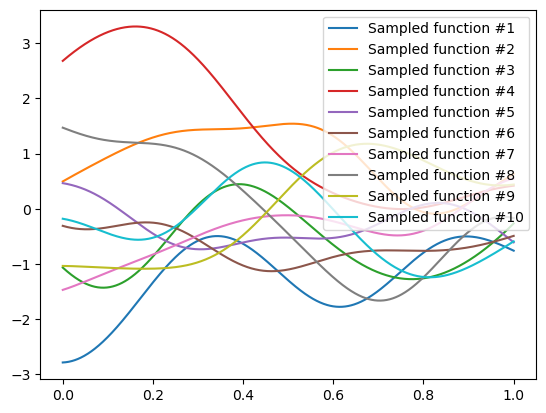

In [124]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1,10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)

N = 31 * 29 + 1
t = np.linspace(0,1,N)
dt = t[1]-t[0]

X = t.reshape(-1, 1)
n_samples=10

y_samples = gpr.sample_y(X, n_samples)

plt.figure()
for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        t,
        single_prior,
        # linestyle="--",
        # alpha=0.7,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend()

forcing_terms = y_samples.T

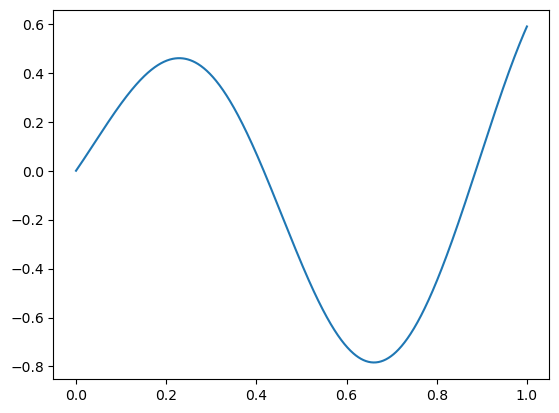

In [125]:
dt = t[1]-t[0]
    
def f(t,u, force):
    k = 9.81/0.2
    u0 = u[1]
    u1 = -k*np.sin(u[0]) + force[int(t/dt)]
    U = np.array([u0, u1])
    return U

plt.figure()
# for ft in forcing_terms:
#     sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
#     plt.plot(sol.t, sol.y[1])
sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,forcing_terms[3]), y0=[0,0], t_span=[0,1],t_eval=t)
plt.plot(sol.t, sol.y[1])

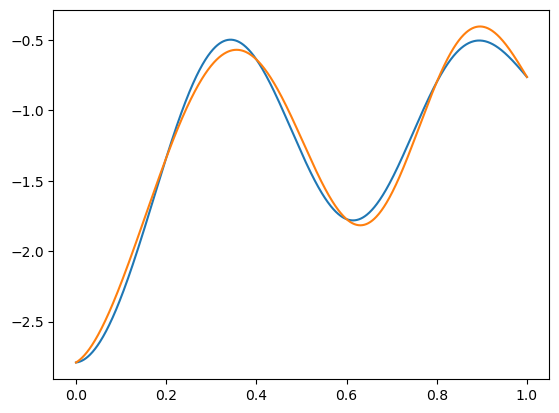

In [126]:
plt.plot(t,forcing_terms[0])
beta = 0.1
plt.plot(t, forcing_terms[0] +  beta * np.sin(5 * np.pi * t))

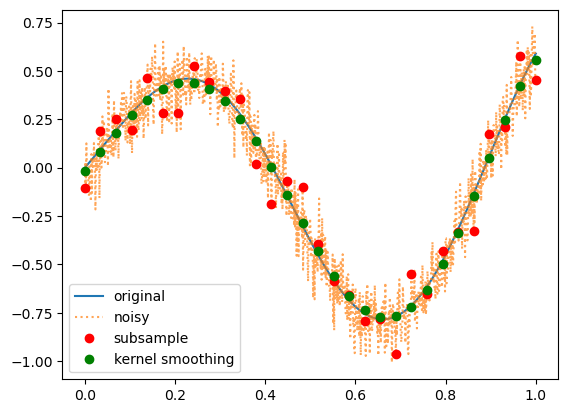

In [129]:
ut = sol.y[1]
noise = np.random.normal(0,0.1,N)
ut_perturbed = ut + noise

u_sample = ut_perturbed[::31]
t_sample = t[::31]

T = t_sample.reshape(-1,1)
UXX = rbf_kernel(T, T, gamma=1)

lam = 1e-3
UXX_inv_u = np.linalg.solve(UXX + lam**2*np.eye(30), u_sample)
smoothed = UXX @ UXX_inv_u

plt.figure()
plt.plot(t, ut, '-', label='original')
plt.plot(t, ut_perturbed, ':', alpha=0.7, label='noisy')
plt.plot(t_sample,u_sample,'ro', label='subsample')
plt.plot(t_sample, smoothed, 'go', label='kernel smoothing')
plt.legend()
plt.show()

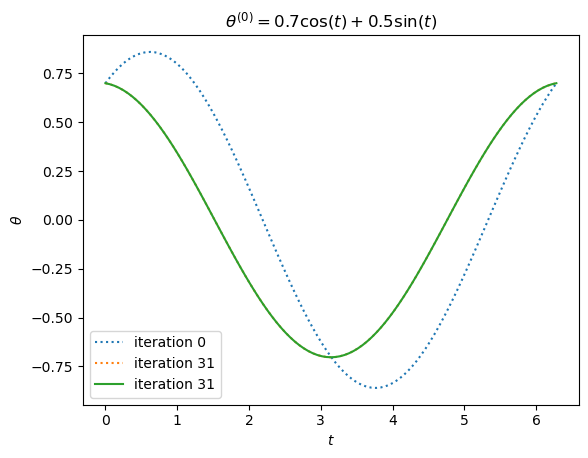

In [95]:
# depracated pendulum
x0 = 0.7
xN = x0
t0 = 0
tN = 2* np.pi
N = 101
t = np.linspace(t0, tN, N)
h = t[1] - t[0]


def F(x):
    y = np.zeros((N-2,1))
    for i in range(N-2):
        y[i] = x[i] - 2*x[i+1] + x[i+2] + h**2*np.sin(x[i+1])
    return y

def J(x):
    y = np.zeros((N-2,N-2))

    for i in range(N-2):
        y[i, i] = -2 + h**2*np.cos(x[i+1])
        if(i>1):
            y[i, i-1] = 1
        if(i<N-3):
            y[i, i+1] = 1

    return y

max_steps = 500
x = 0.7 * np.cos(t) + 0.5 * np.sin(t)
k = 0
plt.figure()
X = [x]
while np.max(np.abs(F(x))) >= 1e-8 and k < max_steps:
    dx = np.linalg.solve(J(x), F(x))
    new_x = np.zeros_like(x)
    new_x[0] = x0
    new_x[-1] = xN
    new_x[1:-1] = x[1:-1] - dx[:,0]
    x = new_x
    k += 1
    X.append(new_x)
plt.plot(t,X[0],':',label=f'iteration {0}')
plt.plot(t,X[-1],':',label=f'iteration {len(X)-1}')
plt.plot(t,x,'-',label=f'iteration {len(X)-1}')

plt.legend()
plt.title(r'$\theta^{(0)} = 0.7\cos(t) + 0.5 \sin(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta$')
plt.show()


In [96]:
noise = np.random.normal(0,0.1,101)
noise

array([-0.13490799,  0.11111725,  0.08969549,  0.02968469,  0.05031429,
        0.0300419 ,  0.00378719, -0.19284491,  0.03716231, -0.06880471,
       -0.01721677, -0.25992121, -0.0244698 ,  0.07242684, -0.09983696,
       -0.12685057, -0.25904457,  0.21552896,  0.02666763,  0.15065126,
        0.0077116 , -0.08799963,  0.03554954,  0.09073552,  0.16608122,
        0.14928241, -0.14426266,  0.04996765, -0.20039932, -0.07557437,
       -0.19815038, -0.06957432,  0.2023326 , -0.28792218, -0.10935878,
        0.08856714, -0.03395821,  0.07541431, -0.0855043 ,  0.13447358,
        0.08441667, -0.08693354, -0.03114437, -0.14364098, -0.04056262,
       -0.0618799 ,  0.02784756,  0.10720889, -0.05290939,  0.09022421,
        0.07221153, -0.02865942, -0.05211569,  0.1754321 , -0.05500694,
        0.08905954,  0.105514  , -0.1046138 , -0.09588684, -0.34157833,
       -0.04962188,  0.19339251, -0.0630468 , -0.10278793, -0.00867557,
        0.18521183, -0.05647717,  0.03656848,  0.03588025, -0.04

In [97]:
signal = x + noise
signal[0] = x[0]
signal[-1] = x[-1]
# t
df = pd.DataFrame(np.array([t,signal]).T,columns=['t','theta'])
df.to_csv('pendulum_data.csv', index=False)

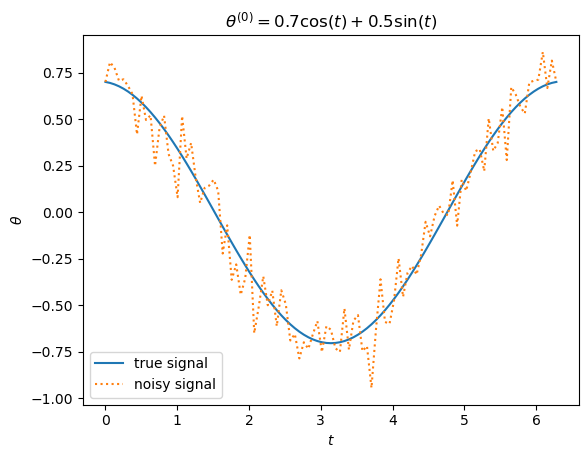

In [98]:
plt.figure()
plt.plot(t,x,'-',label=f'true signal')
plt.plot(t,signal,':',label=f'noisy signal')

plt.legend()
plt.title(r'$\theta^{(0)} = 0.7\cos(t) + 0.5 \sin(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta$')
plt.show()

In [99]:
# smoothing
T = t.reshape(-1,1)
UXX = rbf_kernel(T, T, gamma=1)
# UXX = polynomial_kernel(T,T, degree=4)

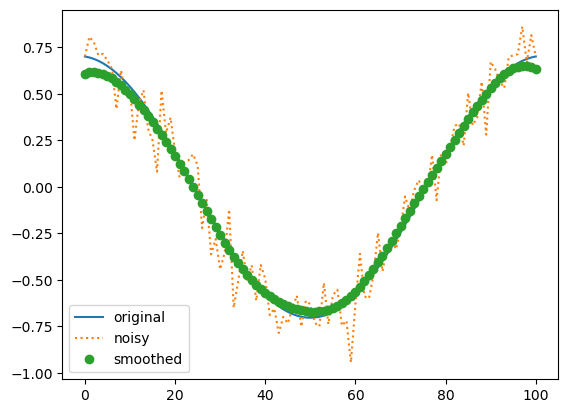

In [100]:
lam = 1
data = df.to_numpy()
u = signal
UXX_inv_u = np.linalg.solve(UXX + lam**2*np.eye(101), u)
smoothed = UXX @ UXX_inv_u

plt.figure()
plt.plot(x, '-', label='original')
plt.plot(signal, ':', label='noisy')
plt.plot(smoothed, 'o', label='smoothed')
plt.legend()
plt.show()